In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Generate pseudo-data

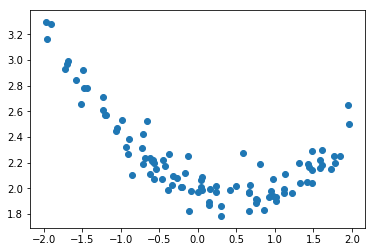

In [135]:
n = 100
x = 4.0 * (np.random.rand(n) - 0.5)
xfeat = np.column_stack((x, x**2, x**3, x**4, x**5))
y = 2.0 - 0.2*x + 0.2*x**2 + 0.1*np.random.randn(n)

plt.scatter(x, y)

Create a function to generate training batches

In [136]:
def get_batches(xfeat, y, batch_size):
    n = xfeat.shape[0]
    n_batches = n // batch_size
    for i in range(n_batches):
        yield xfeat[i*batch_size:(i + 1)*batch_size,:], y[i*batch_size:(i + 1)*batch_size]

Create a very simple architecture with one hidden and a l2 regulariser

In [137]:
def neural_network_input(n_features):
    features = tf.placeholder(tf.float32, (None, n_features))
    target = tf.placeholder(tf.float32, (None, ))
    learning_rate = tf.placeholder(tf.float32)
    l2penalty = tf.placeholder(tf.float32)
    return features, target, learning_rate, l2penalty
    
def hidden_layer(features, n_hidden):
    input_size = features.get_shape().as_list()[1]
    W = tf.Variable(tf.truncated_normal((input_size, n_hidden), stddev=1 / np.sqrt(n_hidden)))
    b = tf.Variable(tf.zeros(n_hidden))
    hidden = tf.nn.relu(tf.matmul(features, W) + b)
    return hidden, W, b

def output_layer(hidden_layer, n_hidden):
    W2 = tf.Variable(tf.truncated_normal((n_hidden, 1), stddev=1 / np.sqrt(n_hidden)))
    b2 = tf.Variable(tf.constant(0.1))
    output = tf.matmul(hidden_layer, W2) + b2
    return output, W2, b2

def neural_network_training(output, target, learning_rate, l2penalty, W, W2):
    loss = tf.reduce_mean(tf.squared_difference(output, target)) + \
            l2penalty * (tf.reduce_sum(tf.square(W)) + tf.reduce_sum(tf.square(W2)))
    optim = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return loss, optim

class neural_network():
    def __init__(self, n_features, n_hidden):
        # Build
        features, target, learning_rate, l2penalty = neural_network_input(n_features)
        hidden, W, b = hidden_layer(features, n_hidden)
        output, W2, b2 = output_layer(hidden, n_hidden)
        loss, optim = neural_network_training(output, target, learning_rate, l2penalty, W, W2)
        # Assign
        self.features, self.target = features, target
        self.learning_rate, self.l2penalty = learning_rate, l2penalty
        self.hidden, self.output = hidden, output
        self.loss, self.optim = loss, optim

Now create the neural network

In [138]:
n_features = xfeat.shape[1]
n_hidden = 8

tf.reset_default_graph()
nn = neural_network(n_features, n_hidden)
nn.__dict__

{'features': <tf.Tensor 'Placeholder:0' shape=(?, 5) dtype=float32>,
 'hidden': <tf.Tensor 'Relu:0' shape=(?, 8) dtype=float32>,
 'l2penalty': <tf.Tensor 'Placeholder_3:0' shape=<unknown> dtype=float32>,
 'learning_rate': <tf.Tensor 'Placeholder_2:0' shape=<unknown> dtype=float32>,
 'loss': <tf.Tensor 'add_3:0' shape=<unknown> dtype=float32>,
 'optim': <tf.Operation 'Adam' type=NoOp>,
 'output': <tf.Tensor 'add_1:0' shape=(?, 1) dtype=float32>,
 'target': <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=float32>}

Train the network

epoch  1 training loss 2.9595
epoch 10 training loss 0.0186
epoch 20 training loss 0.0126


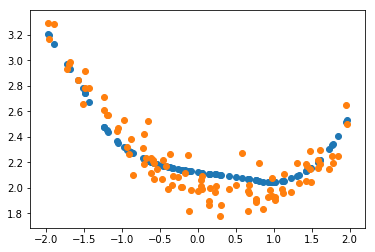

In [165]:
epochs = 20
batch_size = 1
print_every_steps = 1000
lr = 0.05
penalty = 0.02

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    step = 0
    for epoch in range(epochs):
        for batch_x, batch_y in get_batches(xfeat, y, batch_size):
            feed = {nn.features: batch_x, nn.target: batch_y, nn.learning_rate: lr, nn.l2penalty: penalty}
            _, l = sess.run([nn.optim, nn.loss], feed_dict = feed)
            if step == 0 or (step + 1) % print_every_steps == 0:
                print("epoch %2d training loss %4.4f" % (epoch+1, l))
            step += 1
            
    output = sess.run(nn.output, feed_dict = {nn.features: xfeat, nn.target: y})
    plt.scatter(x, output)
    plt.scatter(x, y)
    